<a href="https://colab.research.google.com/github/Cristobal010/cristobal/blob/master/Hito_2_GF_Bascu%C3%B1%C3%A1n_Crist%C3%B3bal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install yfinance
!pip install scipy

In [42]:
import yfinance as yf
from datetime import datetime
#Acción del Banco de Chile en Yahoo Finance

#accion = "CHILE.SN"
accion = "BCH"

datos = yf.Ticker(accion)
#obtencion de datos historicos
historico = datos.history(period="1y")
#precio actual
current_price = datos.history(period="1d")["Close"][0]
print(f"Precio actual de {accion}: {current_price}")

# Obtención de la volatilidad del activo subyacente :
daily_returns = historico["Close"].pct_change().dropna()
annualized_volatility = daily_returns.std() * (252**0.5)
print(f"Volatilidad anualizada: {annualized_volatility}")

simbolo_tesoro = "^TNX"  # ^TNX representa el bono del Tesoro de EE. UU. a 10 años

#datos del bono del Tesoro de USA
datos_tesoro = yf.Ticker(simbolo_tesoro)

#último precio del bono del Tesoro de EE. UU. a 10 años (rendimiento)
tasa_libre_riesgo = datos_tesoro.history(period="1d")["Close"].iloc[-1] / 100  # El rendimiento se expresa en porcentaje

#  tasa libre de riesgo (rendimiento del bono del Tesoro a 10 años)
print("Tasa libre de riesgo (rendimiento del bono del Tesoro a 10 años):", tasa_libre_riesgo)

#print(historico)

#info de las opciones relacionadas
option_chain = datos.option_chain()
#tiempos de vencimiento de las opciones
exp_dates = datos.options
tiempo_exp = [(datetime.strptime(exp_date, '%Y-%m-%d') - datetime.now()).days / 365 for exp_date in exp_dates]
precio_strike = option_chain.calls['strike']
print("Precios de ejercicio: ", precio_strike)
print("Tiempo hasta la expiración (años): ", tiempo_exp)

Precio actual de BCH: 19.530000686645508
Volatilidad anualizada: 0.24798528263029637
Tasa libre de riesgo (rendimiento del bono del Tesoro a 10 años): 0.04845000267028809
Precios de ejercicio:  0    20.0
Name: strike, dtype: float64
Tiempo hasta la expiración (años):  [0.057534246575342465, 0.23013698630136986, 0.4794520547945205]


# Valoración opciones aplicada

El modelo Black-Scholes fue desarrollado por dos matematicos llamados Fisher Black y Myron Scholes. Black-Scholes, en un principio, fue utilizado para la valorizacion de opciones las cuales no repartían dividendos, es decir, calcular cual debería ser el precio adecuado para una opción financiera. Con el paso de los años, el calculo fue ampliado a todo tipo de opciones.

Este modelo ha sido considerado uno de los pilares fundamentales de la teoría financiera moderna, logrando en el año 1997 el premio Nobel de economía.

Tome en consideración el modelo continuio de Black and Scholes:

$$C(S,t)=S\cdot\Phi(d_1)-K\exp(-R\cdot t)\cdot\Phi(d_2)$$

donde $d_1=\frac{\log\frac{S}{K}+\left(R+\frac{\sigma^2}{2}\right)\cdot t}{\sqrt{\sigma^2\cdot t}}$ y $d_2=d_1-\sqrt{\sigma^2\cdot t}$.

Defina los parámetros asociados a valores del activo definido en la Tarea 1 y calcule el valor de una opción de compra.

## Black-Scholes

In [45]:
import math
from scipy.stats import norm
# Parámetros de test
#K = 100
#r = 0.02
#sigma = 0.2
#T = 0.5
#S = 102
# Resultado esperado CALL
# 7.28815118277163
def black_scholes_call(S, K, T, r, sigma):
  d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
  d2 = d1 - sigma * math.sqrt(T)
  call_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
  return call_price


# Parámetros para la opción de compra, con fecha 26-10-2023

precio_activo = 19.530000686645508  # Precio actual del activo Banco de Chile (S) (dia 26-10-2023)
precio_ejercicio = 20  # Precio de ejercicio de la opción (K)
tiempo_expiracion = 0.48  # Tiempo hasta la expiración de la opción (en años), madurez (T)
tasa_interes = 0.04845000267028809  # Tasa libre de riesgo  (r)
volatilidad = 0.24798528263029637  # Volatilidad del activo subyacente (sigma)

# Calculo de el precio de la opción de compra utilizando el modelo Black-Scholes
precio_opcion = black_scholes_call(precio_activo, precio_ejercicio, tiempo_expiracion, tasa_interes, volatilidad)

# Print de el precio de la opción de compra
print("Precio de la opción de compra:", precio_opcion)

Precio de la opción de compra: 1.3322140660129254


## Segundo Modelo de valoración
Modelo de Regresión Monte Carlo: El modelo de Monte Carlo corresponde a un método flexible y sencillo que implica la simulación de múltiples escenarios (mientras más grande sea el número de simulaciones, mayor precisión tendrá la estimación del precio de la opción) con base en algún proceso estocástico del precio de un activo financiero.
La simulación encuentra varios valores de St y para cada uno de estos valores se calcula el pago de la opción, se estima un valor medio de esta variable y se trae a valor presente utilizando la tasa libre de riesgo en vez de la tasa de descuento. La estimación del precio de la opción, esta dada por la siguiente formula:
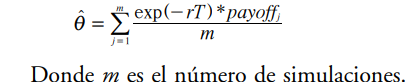

In [46]:
import numpy as np
def montecarlo_option_pricing(S, K, T, r, sigma, num_simulaciones):
  np.random.seed(42)  # Establecemos una semilla para reproducibilidad
  z = np.random.normal(0, 1, num_simulaciones)  # Generamos números aleatorios de una distribución normal estándar
  ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) *z )#z  # Calculamos los precios del activo en el futuro
  payoff = np.maximum(ST - K, 0)  # Calculamos el payoff de la opción de compra
  option_price = np.exp(-r * T) * np.mean(payoff)  # Calculamos el precio de la opción utilizando el valor presente
  return option_price


# Parámetros para la opción de compra, con fecha 26-10-2023
precio_activo = 19.530000686645508  # Precio actual del activo Banco de Chile (S) (dia 26-10-2023)
precio_ejercicio = 20  # Precio de ejercicio de la opción (K)
tiempo_expiracion = 0.48  # Tiempo hasta la expiración de la opción (en años), madurez (T)
tasa_interes = 0.04845000267028809  # Tasa libre de riesgo  (r)
volatilidad = 0.24798528263029637  # Volatilidad del activo subyacente (sigma)
num_simulaciones = 100000
# Calculo de el precio de la opción de compra utilizando el modelo de Regresión Monte Carlo
precio_opcion = montecarlo_option_pricing(precio_activo, precio_ejercicio, tiempo_expiracion, tasa_interes, volatilidad, num_simulaciones)

# Imprimir el precio de la opción de compra
print("Precio de la opción de compra usando Monte Carlo:", precio_opcion)

Precio de la opción de compra usando Monte Carlo: 1.3355523220243686


##Analisis

Observando los resultados, tenemos que para el caso del modelo de Black-Scholes el precio de la opción arroja un valor de 1.3322140660129254, mientras que utilizando modelo de Monte Carlo el precio de la opción tiene un valor de 1.3355523220243686 dolares. Esta similitud en los resultados se debe primero porque ambos asumen que la distribución de probabilidad de los retornos corresponde a una distribución normal. Otro aspecto para tomar en cuenta es que se está analizando en este caso una opción para el corto plazo, donde Black-Scholes realiza buenas estimaciones en estos periodos de tiempo, mientras que Monte Carlo es utilizado mayormente para valorización de opciones más complejas y en situaciones más cercanas a la realidad (Black-Scholes asume ciertos supuestos, por ejemplo: no hay costes de transacciones o impuestos). Y, por último, tiene que ver con que se realizaron varias simulaciones en el método de Monte Carlo, por lo que el resultado tiende a ser más preciso, mientras que, si ponemos el número de simulaciones más bajo, obtenemos una mayor diferencia en los precios obtenidos.

##Reporte grupal

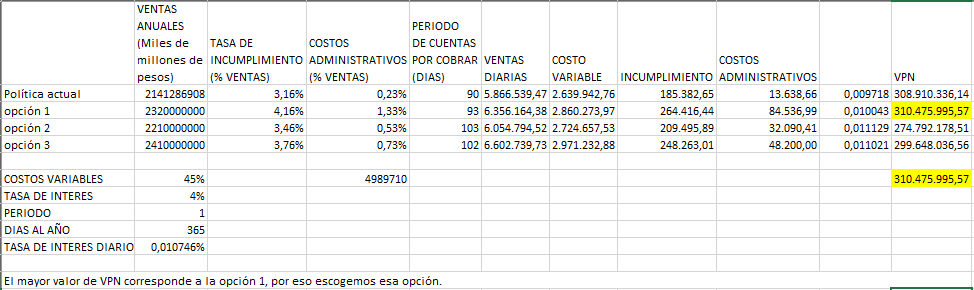

En base a lo calculado en el excel sobre el caso Administración de Efectivo de Braam Industries, teniendo en cuenta el activo de ENEL podemos concluir que la politica que debe adoptar la empresa corresponde a la opción 1 al ser la opción con el mayor VPN dentro de todas las alternativas posibles. Por otro lado, no es factible que la opción 3 tenga una tasa de incumplimiento y costos administrativos inferiores a la opción 2 por lo que esta afirmación es errónea.